In [1]:
%%writefile cuda_implement.cu

#include <cuda_runtime.h>
#include <cublas_v2.h>
#include <cusolverDn.h>
#include <curand.h>
#include <curand_kernel.h>
#include <iostream>
#include <fstream>
#include <vector>
#include <chrono>
#include <cmath>
#include <iomanip>

#define CHECK_CUDA(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            std::cerr << "CUDA error at " << __FILE__ << ":" << __LINE__ << " - " << cudaGetErrorString(err) << std::endl; \
            exit(1); \
        } \
    } while(0)

#define CHECK_CUBLAS(call) \
    do { \
        cublasStatus_t err = call; \
        if (err != CUBLAS_STATUS_SUCCESS) { \
            std::cerr << "CUBLAS error at " << __FILE__ << ":" << __LINE__ << std::endl; \
            exit(1); \
        } \
    } while(0)

#define CHECK_CUSOLVER(call) \
    do { \
        cusolverStatus_t err = call; \
        if (err != CUSOLVER_STATUS_SUCCESS) { \
            std::cerr << "CUSOLVER error at " << __FILE__ << ":" << __LINE__ << std::endl; \
            exit(1); \
        } \
    } while(0)

#define CHECK_CURAND(call) \
    do { \
        curandStatus_t err = call; \
        if (err != CURAND_STATUS_SUCCESS) { \
            std::cerr << "CURAND error at " << __FILE__ << ":" << __LINE__ << std::endl; \
            exit(1); \
        } \
    } while(0)

// CUDA kernel functions must be outside the class
__global__ void centerDataKernel(float *data, float *centered_data, float *means, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int idy = blockIdx.y * blockDim.y + threadIdx.y;
    
    if (idx < n && idy < n) {
        centered_data[idy * n + idx] = data[idy * n + idx] - means[idx];
    }
}

__global__ void computeMeansKernel(float *data, float *means, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    
    if (idx < n) {
        float sum = 0.0f;
        for (int i = 0; i < n; i++) {
            sum += data[i * n + idx];
        }
        means[idx] = sum / n;
    }
}

class CudaTimer {
private:
    cudaEvent_t start, stop;
    
public:
    CudaTimer() {
        CHECK_CUDA(cudaEventCreate(&start));
        CHECK_CUDA(cudaEventCreate(&stop));
    }
    
    ~CudaTimer() {
        cudaEventDestroy(start);
        cudaEventDestroy(stop);
    }
    
    void startTimer() {
        CHECK_CUDA(cudaEventRecord(start));
    }
    
    float stopTimer() {
        CHECK_CUDA(cudaEventRecord(stop));
        CHECK_CUDA(cudaEventSynchronize(stop));
        float milliseconds = 0;
        CHECK_CUDA(cudaEventElapsedTime(&milliseconds, start, stop));
        return milliseconds;
    }
};

class CudaSVDPCA {
private:
    int n;
    float *d_matrix, *d_U, *d_S, *d_VT;
    float *d_covariance, *d_eigenvalues, *d_eigenvectors;
    float *d_centered_data, *d_principal_components;
    
    cublasHandle_t cublasHandle;
    cusolverDnHandle_t cusolverHandle;
    curandGenerator_t curandGen;
    
    std::vector<float> timing_data;
    std::vector<std::string> timing_labels;

public:
    CudaSVDPCA(int size) : n(size) {
        // Allocate GPU memory
        CHECK_CUDA(cudaMalloc(&d_matrix, n * n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_U, n * n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_S, n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_VT, n * n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_covariance, n * n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_eigenvalues, n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_eigenvectors, n * n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_centered_data, n * n * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_principal_components, n * n * sizeof(float)));
        
        // Initialize handles
        CHECK_CUBLAS(cublasCreate(&cublasHandle));
        CHECK_CUSOLVER(cusolverDnCreate(&cusolverHandle));
        CHECK_CURAND(curandCreateGenerator(&curandGen, CURAND_RNG_PSEUDO_DEFAULT));
        CHECK_CURAND(curandSetPseudoRandomGeneratorSeed(curandGen, 1234ULL));
    }
    
    ~CudaSVDPCA() {
        cudaFree(d_matrix);
        cudaFree(d_U);
        cudaFree(d_S);
        cudaFree(d_VT);
        cudaFree(d_covariance);
        cudaFree(d_eigenvalues);
        cudaFree(d_eigenvectors);
        cudaFree(d_centered_data);
        cudaFree(d_principal_components);
        
        cublasDestroy(cublasHandle);
        cusolverDnDestroy(cusolverHandle);
        curandDestroyGenerator(curandGen);
    }
    
    void fillMatrixRandom() {
        CudaTimer timer;
        timer.startTimer();
        
        CHECK_CURAND(curandGenerateUniform(curandGen, d_matrix, n * n));
        
        float elapsed = timer.stopTimer();
        timing_data.push_back(elapsed);
        timing_labels.push_back("Matrix Random Fill");
        
        std::cout << "Matrix filled with random numbers: " << elapsed << " ms" << std::endl;
    }
    
    void matrixOperations() {
        CudaTimer timer;
        timer.startTimer();
        
        const float alpha = 1.0f, beta = 0.0f;
        
        // Matrix multiplication: A * A^T (for demonstration)
        CHECK_CUBLAS(cublasSgemm(cublasHandle, CUBLAS_OP_N, CUBLAS_OP_T,
                                n, n, n, &alpha, d_matrix, n, d_matrix, n,
                                &beta, d_covariance, n));
        
        float elapsed = timer.stopTimer();
        timing_data.push_back(elapsed);
        timing_labels.push_back("Matrix Operations");
        
        std::cout << "Matrix operations completed: " << elapsed << " ms" << std::endl;
    }
    
    void computeEigendecomposition() {
        CudaTimer timer;
        timer.startTimer();
        
        // Query workspace size
        int lwork = 0;
        CHECK_CUSOLVER(cusolverDnSsyevd_bufferSize(cusolverHandle, CUSOLVER_EIG_MODE_VECTOR,
                                                  CUBLAS_FILL_MODE_UPPER, n, d_covariance, n,
                                                  d_eigenvalues, &lwork));
        
        float *d_work;
        int *d_info;
        CHECK_CUDA(cudaMalloc(&d_work, lwork * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_info, sizeof(int)));
        
        // Copy covariance matrix for eigendecomposition
        CHECK_CUDA(cudaMemcpy(d_eigenvectors, d_covariance, n * n * sizeof(float), cudaMemcpyDeviceToDevice));
        
        // Compute eigendecomposition
        CHECK_CUSOLVER(cusolverDnSsyevd(cusolverHandle, CUSOLVER_EIG_MODE_VECTOR,
                                       CUBLAS_FILL_MODE_UPPER, n, d_eigenvectors, n,
                                       d_eigenvalues, d_work, lwork, d_info));
        
        // Check convergence
        int info;
        CHECK_CUDA(cudaMemcpy(&info, d_info, sizeof(int), cudaMemcpyDeviceToHost));
        if (info != 0) {
            std::cerr << "Eigendecomposition failed with info = " << info << std::endl;
        }
        
        cudaFree(d_work);
        cudaFree(d_info);
        
        float elapsed = timer.stopTimer();
        timing_data.push_back(elapsed);
        timing_labels.push_back("Eigendecomposition");
        
        std::cout << "Eigendecomposition completed: " << elapsed << " ms" << std::endl;
    }
    
    void computeSVD() {
        CudaTimer timer;
        timer.startTimer();
        
        // Query workspace size for SVD
        int lwork = 0;
        CHECK_CUSOLVER(cusolverDnSgesvd_bufferSize(cusolverHandle, n, n, &lwork));
        
        float *d_work;
        float *d_rwork = nullptr; // For complex matrices only
        int *d_info;
        CHECK_CUDA(cudaMalloc(&d_work, lwork * sizeof(float)));
        CHECK_CUDA(cudaMalloc(&d_info, sizeof(int)));
        
        // Copy original matrix for SVD
        float *d_A_copy;
        CHECK_CUDA(cudaMalloc(&d_A_copy, n * n * sizeof(float)));
        CHECK_CUDA(cudaMemcpy(d_A_copy, d_matrix, n * n * sizeof(float), cudaMemcpyDeviceToDevice));
        
        // Compute SVD: A = U * S * V^T
        CHECK_CUSOLVER(cusolverDnSgesvd(cusolverHandle, 'A', 'A', n, n,
                                       d_A_copy, n, d_S, d_U, n, d_VT, n,
                                       d_work, lwork, d_rwork, d_info));
        
        // Check convergence
        int info;
        CHECK_CUDA(cudaMemcpy(&info, d_info, sizeof(int), cudaMemcpyDeviceToHost));
        if (info != 0) {
            std::cerr << "SVD failed with info = " << info << std::endl;
        }
        
        cudaFree(d_A_copy);
        cudaFree(d_work);
        cudaFree(d_info);
        
        float elapsed = timer.stopTimer();
        timing_data.push_back(elapsed);
        timing_labels.push_back("SVD Computation");
        
        std::cout << "SVD completed: " << elapsed << " ms" << std::endl;
    }
    
    void computePCA() {
        CudaTimer timer;
        timer.startTimer();
        
        // Compute column means
        float *d_means;
        CHECK_CUDA(cudaMalloc(&d_means, n * sizeof(float)));
        
        dim3 blockSize(256);
        dim3 gridSize((n + blockSize.x - 1) / blockSize.x);
        computeMeansKernel<<<gridSize, blockSize>>>(d_matrix, d_means, n);
        CHECK_CUDA(cudaDeviceSynchronize());
        
        // Center the data
        dim3 blockSize2D(16, 16);
        dim3 gridSize2D((n + blockSize2D.x - 1) / blockSize2D.x,
                       (n + blockSize2D.y - 1) / blockSize2D.y);
        centerDataKernel<<<gridSize2D, blockSize2D>>>(d_matrix, d_centered_data, d_means, n);
        CHECK_CUDA(cudaDeviceSynchronize());
        
        // Compute covariance matrix: C = (1/(n-1)) * X^T * X
        const float alpha = 1.0f / (n - 1);
        const float beta = 0.0f;
        CHECK_CUBLAS(cublasSgemm(cublasHandle, CUBLAS_OP_T, CUBLAS_OP_N,
                                n, n, n, &alpha, d_centered_data, n,
                                d_centered_data, n, &beta, d_covariance, n));
        
        // Compute eigendecomposition of covariance matrix (already done above)
        // The eigenvectors are the principal components
        
        // Project data onto principal components
        const float alpha_proj = 1.0f, beta_proj = 0.0f;
        CHECK_CUBLAS(cublasSgemm(cublasHandle, CUBLAS_OP_N, CUBLAS_OP_T,
                                n, n, n, &alpha_proj, d_centered_data, n,
                                d_eigenvectors, n, &beta_proj, d_principal_components, n));
        
        cudaFree(d_means);
        
        float elapsed = timer.stopTimer();
        timing_data.push_back(elapsed);
        timing_labels.push_back("PCA Computation");
        
        std::cout << "PCA completed: " << elapsed << " ms" << std::endl;
    }
    
    void saveResults() {
        // Save timing data
        std::ofstream timing_file("timing_results.csv");
        timing_file << "Operation,Time_ms" << std::endl;
        for (size_t i = 0; i < timing_data.size(); i++) {
            timing_file << timing_labels[i] << "," << timing_data[i] << std::endl;
        }
        timing_file.close();
        
        // Save singular values
        std::vector<float> singular_values(n);
        CHECK_CUDA(cudaMemcpy(singular_values.data(), d_S, n * sizeof(float), cudaMemcpyDeviceToHost));
        
        std::ofstream sv_file("singular_values.csv");
        sv_file << "Index,Singular_Value" << std::endl;
        for (int i = 0; i < n; i++) {
            sv_file << i << "," << std::fixed << std::setprecision(6) << singular_values[i] << std::endl;
        }
        sv_file.close();
        
        // Save eigenvalues
        std::vector<float> eigenvalues(n);
        CHECK_CUDA(cudaMemcpy(eigenvalues.data(), d_eigenvalues, n * sizeof(float), cudaMemcpyDeviceToHost));
        
        std::ofstream eigen_file("eigenvalues.csv");
        eigen_file << "Index,Eigenvalue" << std::endl;
        for (int i = 0; i < n; i++) {
            eigen_file << i << "," << std::fixed << std::setprecision(6) << eigenvalues[i] << std::endl;
        }
        eigen_file.close();
        
        // Save first few principal components for visualization
        std::vector<float> pc_data(n * std::min(5, n));
        CHECK_CUDA(cudaMemcpy(pc_data.data(), d_principal_components, 
                             n * std::min(5, n) * sizeof(float), cudaMemcpyDeviceToHost));
        
        std::ofstream pc_file("principal_components.csv");
        pc_file << "PC1,PC2,PC3,PC4,PC5" << std::endl;
        for (int i = 0; i < n; i++) {
            for (int j = 0; j < std::min(5, n); j++) {
                pc_file << std::fixed << std::setprecision(6) << pc_data[j * n + i];
                if (j < std::min(5, n) - 1) pc_file << ",";
            }
            pc_file << std::endl;
        }
        pc_file.close();
        
        std::cout << "Results saved to CSV files for Python visualization" << std::endl;
    }
    
    void printSummary() {
        std::cout << "\n=== CUDA SVD and PCA Summary ===" << std::endl;
        std::cout << "Matrix size: " << n << "x" << n << std::endl;
        std::cout << "Total operations: " << timing_labels.size() << std::endl;
        
        float total_time = 0;
        for (float time : timing_data) {
            total_time += time;
        }
        std::cout << "Total computation time: " << total_time << " ms" << std::endl;
        
        std::cout << "\nTiming breakdown:" << std::endl;
        for (size_t i = 0; i < timing_data.size(); i++) {
            std::cout << "  " << timing_labels[i] << ": " 
                     << timing_data[i] << " ms (" 
                     << std::fixed << std::setprecision(1) 
                     << (timing_data[i] / total_time) * 100 << "%)" << std::endl;
        }
    }
};

int main() {
    const int MATRIX_SIZE = 5000;
    
    std::cout << "Starting CUDA SVD and PCA Implementation" << std::endl;
    std::cout << "Matrix size: " << MATRIX_SIZE << "x" << MATRIX_SIZE << std::endl;
    
    try {
        CudaSVDPCA solver(MATRIX_SIZE);
        
        // Execute the algorithm pipeline
        solver.fillMatrixRandom();
        solver.matrixOperations();
        solver.computeEigendecomposition();
        solver.computeSVD();
        solver.computePCA();
        
        // Save results and print summary
        solver.saveResults();
        solver.printSummary();
        
        std::cout << "\nAll computations completed successfully!" << std::endl;
        
    } catch (const std::exception& e) {
        std::cerr << "Error: " << e.what() << std::endl;
        return 1;
    }
    
    return 0;
}

Overwriting cuda_implement.cu


In [2]:
!nvcc -o cuda_svd_pca cuda_implement.cu -lcublas -lcusolver -lcurand
!./cuda_svd_pca

Starting CUDA SVD and PCA Implementation
Matrix size: 5000x5000
Matrix filled with random numbers: 26.2441 ms
Matrix operations completed: 70.654 ms
Eigendecomposition completed: 383.768 ms
SVD completed: 24160.7 ms
PCA completed: 28.9496 ms
Results saved to CSV files for Python visualization

=== CUDA SVD and PCA Summary ===
Matrix size: 5000x5000
Total operations: 5
Total computation time: 24670.3 ms

Timing breakdown:
  Matrix Random Fill: 26.2441 ms (0.1%)
  Matrix Operations: 70.7 ms (0.3%)
  Eigendecomposition: 383.8 ms (1.6%)
  SVD Computation: 24160.7 ms (97.9%)
  PCA Computation: 28.9 ms (0.1%)

All computations completed successfully!


In [3]:
import numpy as np 

✓ Loaded timing results
✓ Loaded singular values
✓ Loaded eigenvalues
✓ Loaded principal components
🚀 Starting comprehensive CUDA SVD/PCA analysis...

📊 Generating timing analysis...


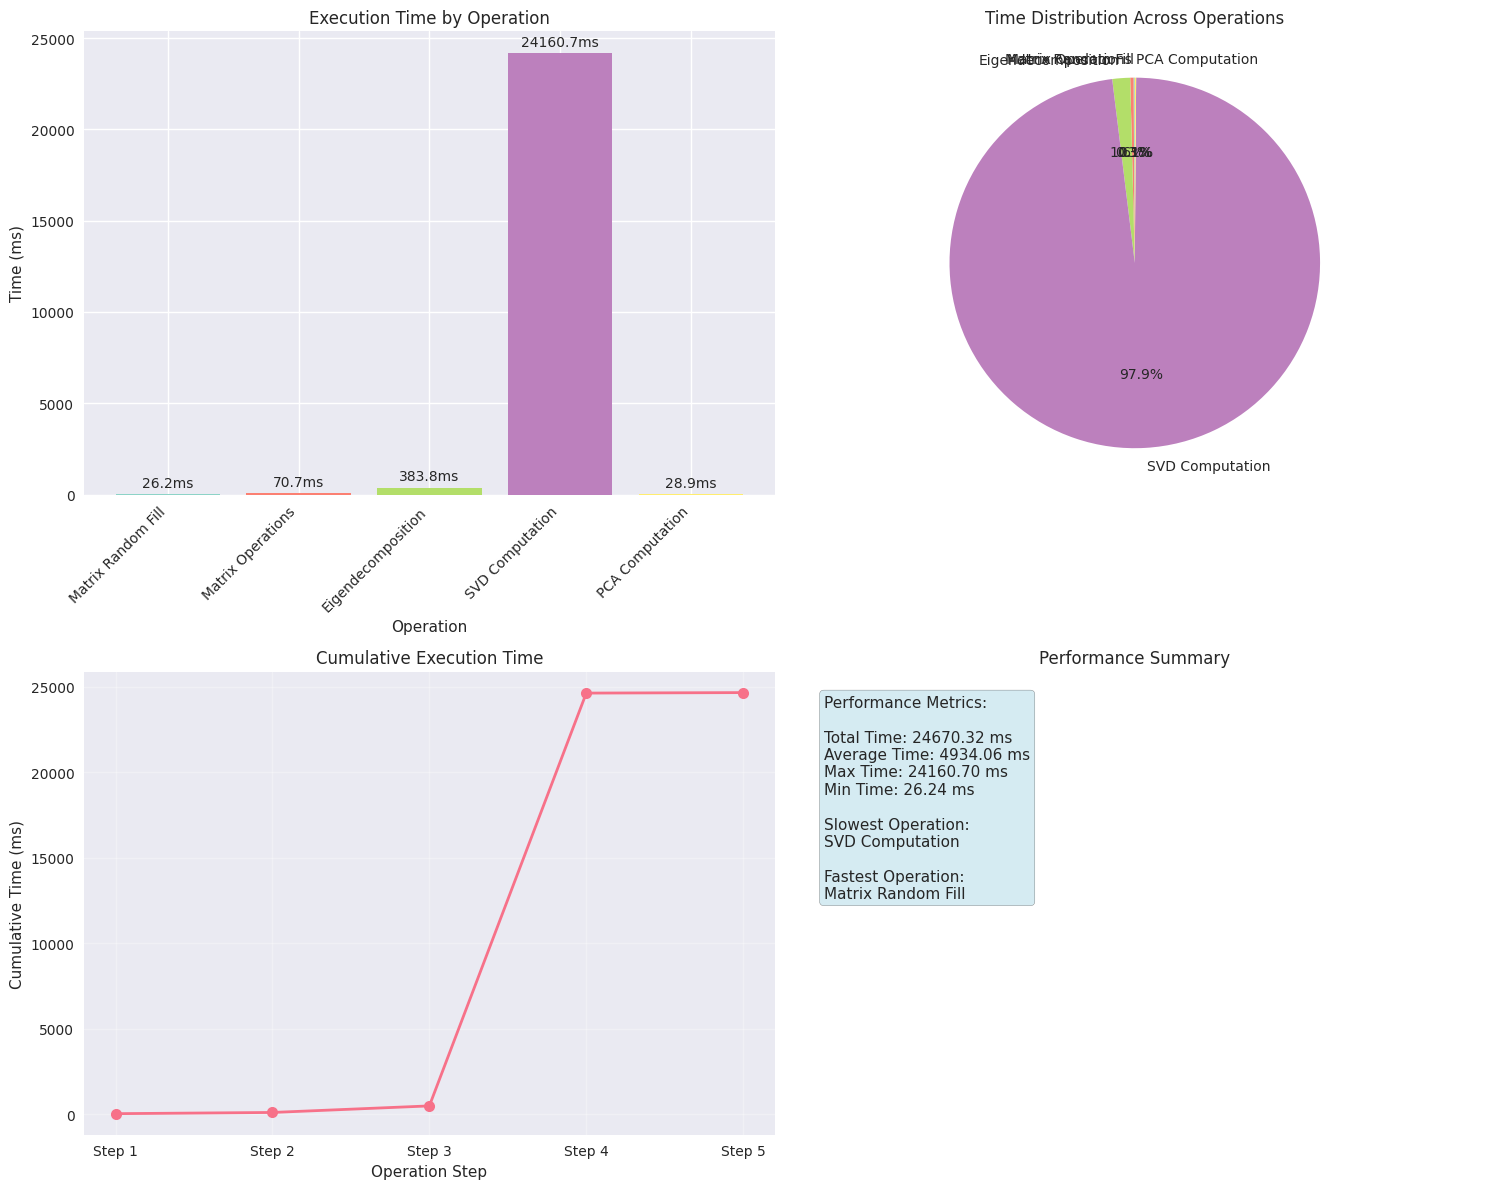


🔢 Generating singular value analysis...


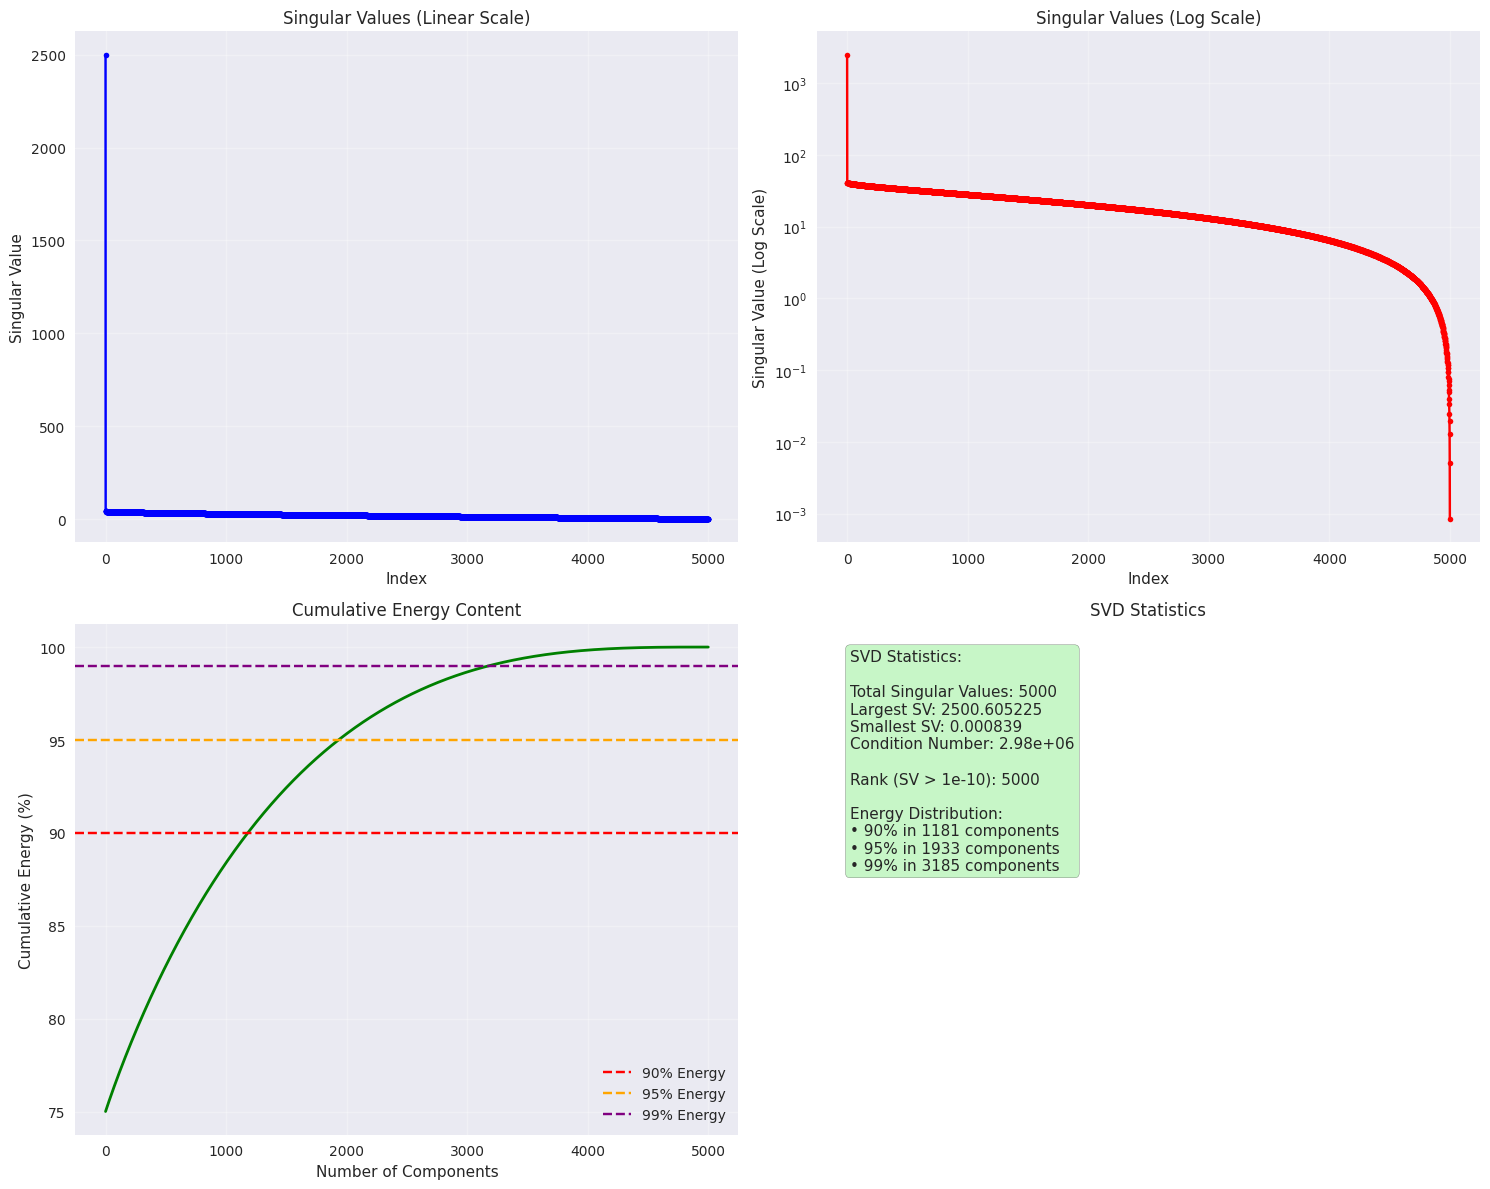


📈 Generating eigenvalue analysis...


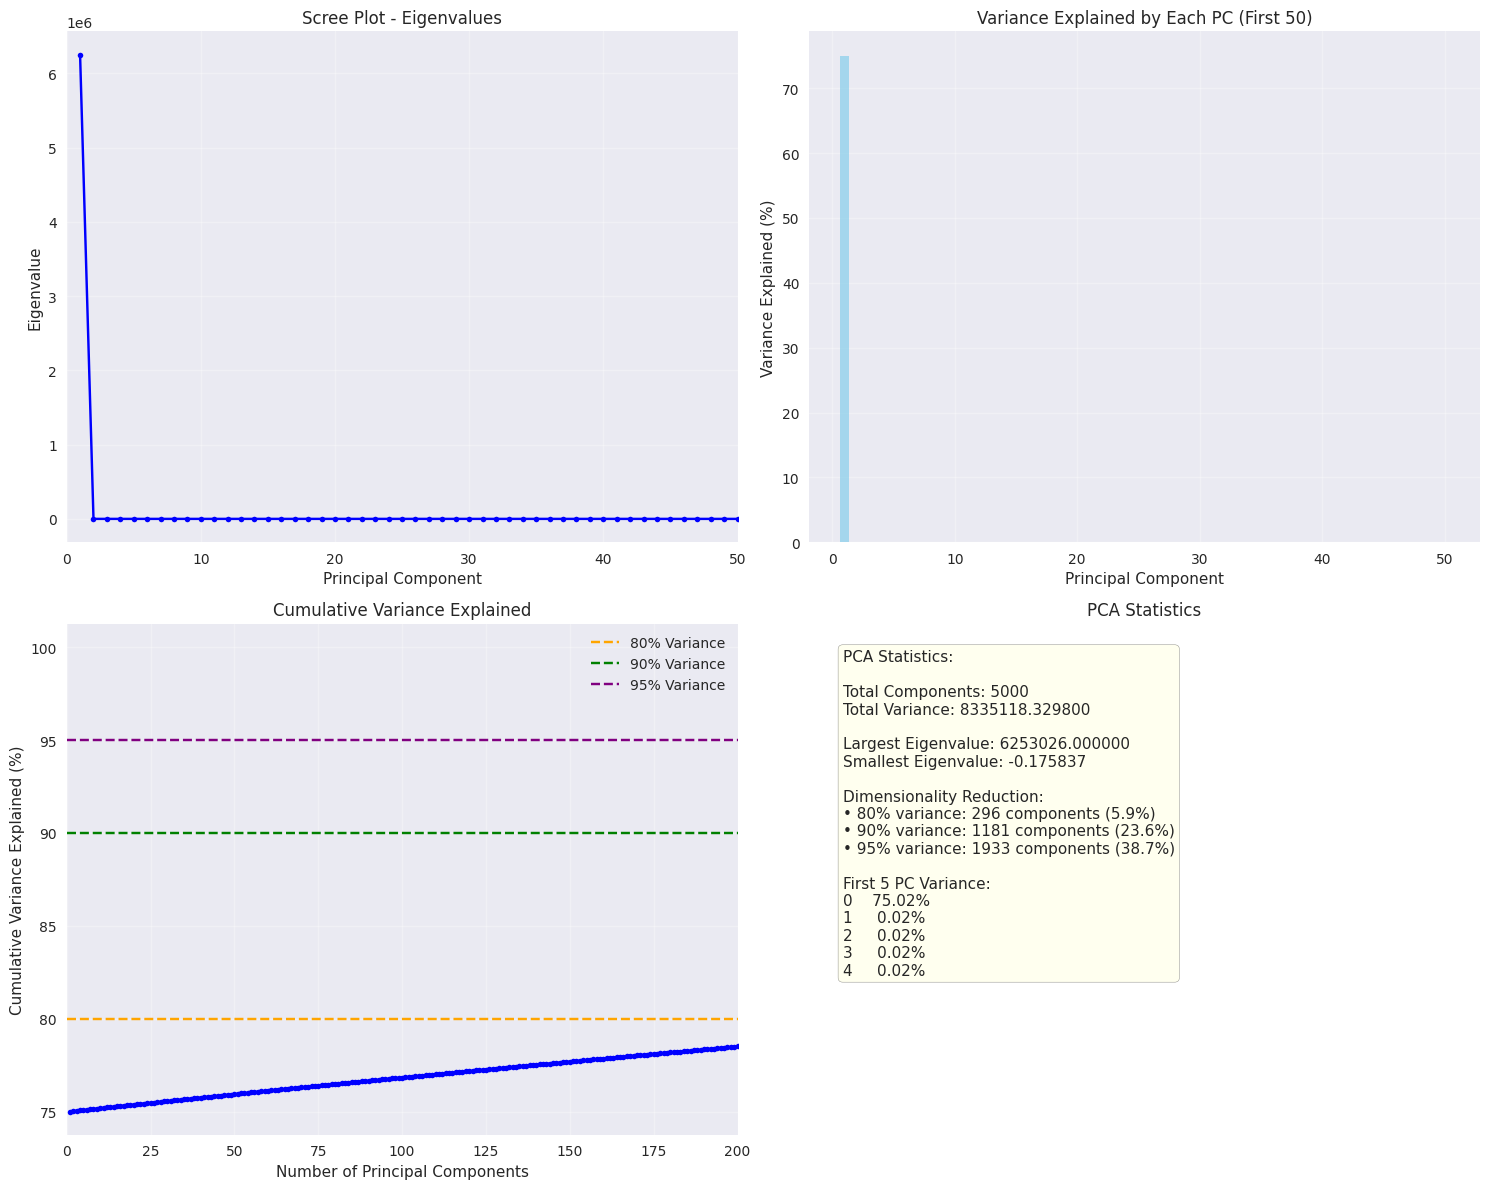


🎯 Generating principal components analysis...


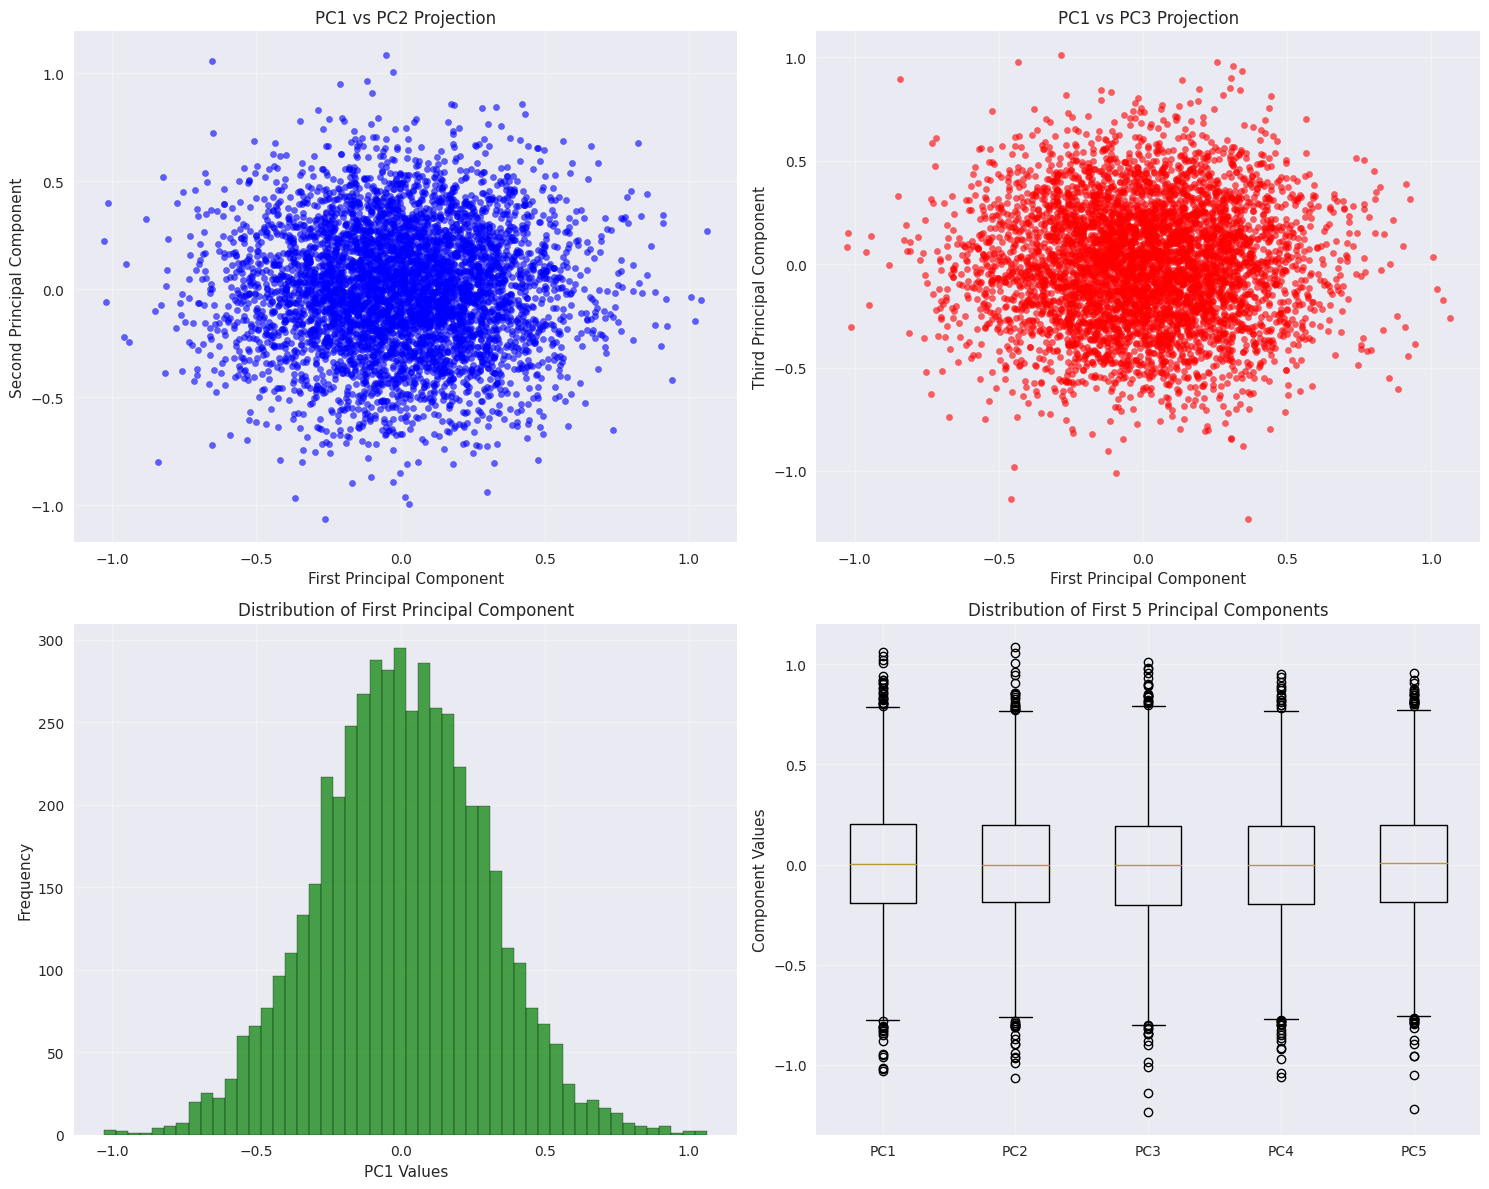


⚖️ Generating comparison analysis...


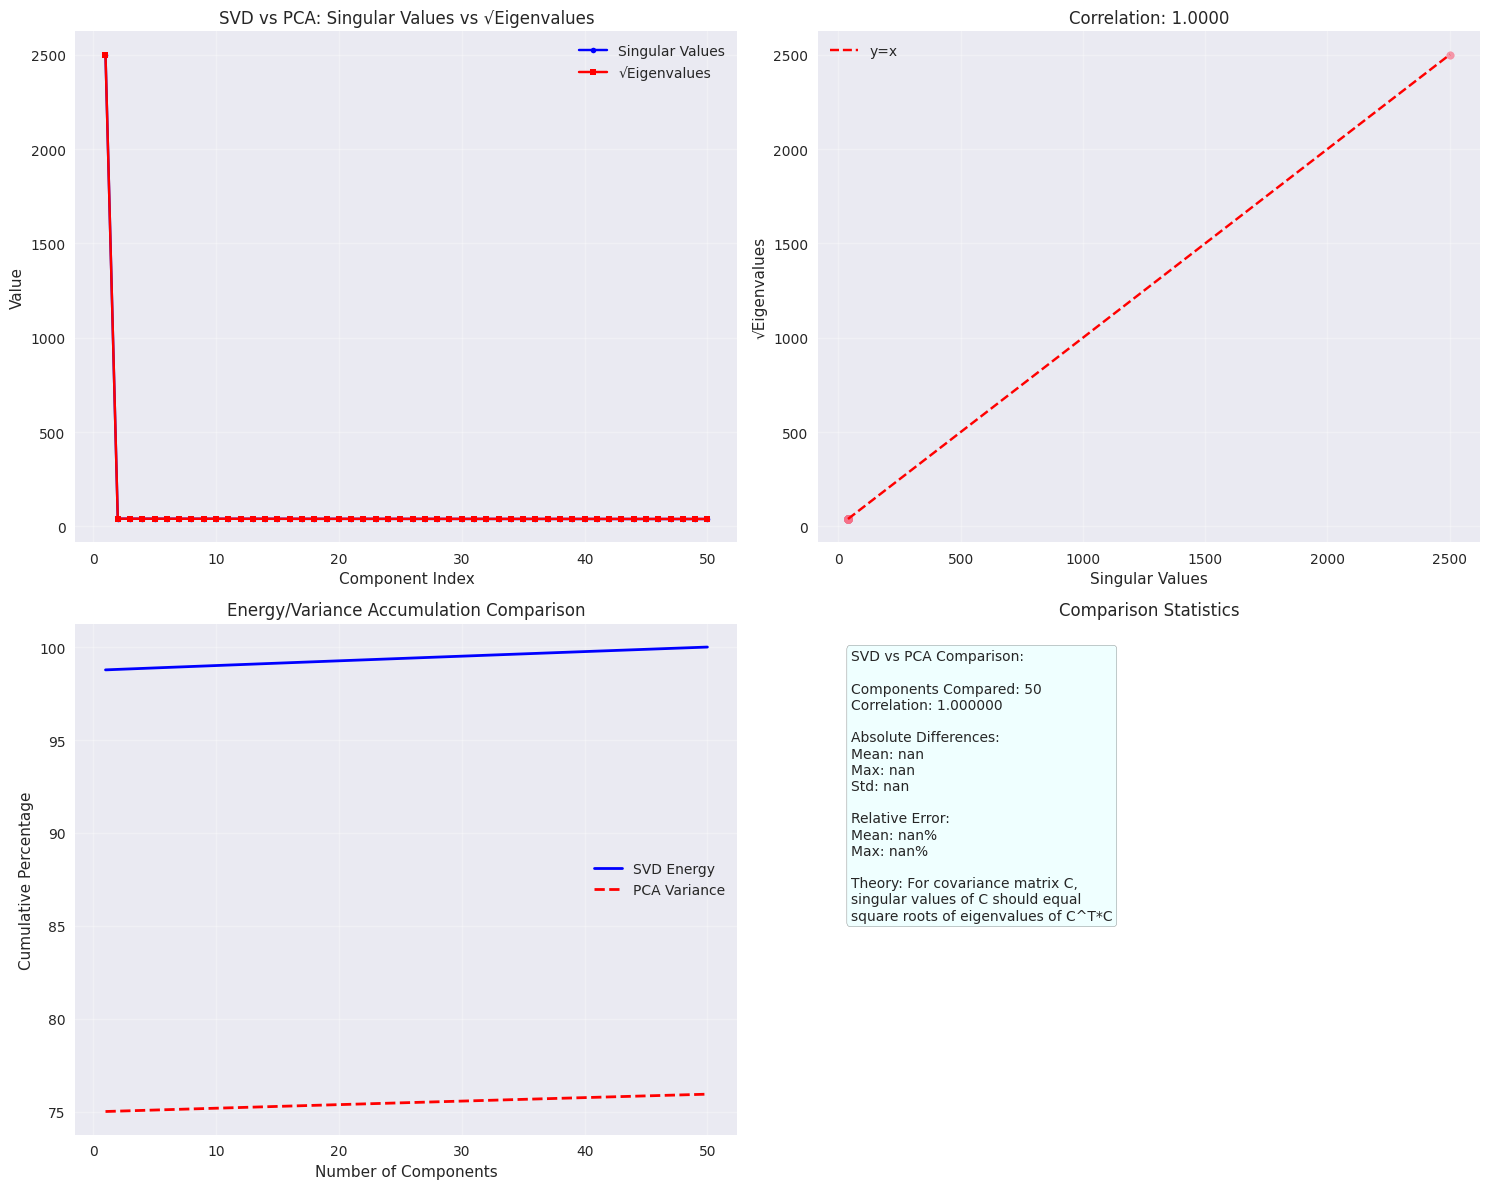


📋 Generating final report...

CUDA SVD and PCA Analysis Report

📊 PERFORMANCE ANALYSIS:
Total execution time: 24670.32 ms
Average operation time: 4934.06 ms
Slowest operation: SVD Computation (24160.70 ms)

🔢 SVD ANALYSIS:
Matrix rank (approx): 5000
Condition number: 2.98e+06
90% energy captured by: 1181 components

📈 PCA ANALYSIS:
Total variance: 8335118.329800
90% variance explained by: 1181 components
Effective dimensionality reduction: 76.4%

📁 FILES GENERATED:
✓ timing_analysis.png
✓ singular_values_analysis.png
✓ eigenvalue_analysis.png
✓ principal_components_analysis.png
✓ svd_pca_comparison.png


✅ printed if all the above analysis succed.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

class SVDPCAVisualizer:
    def __init__(self):
        """Initialize the visualizer and load data."""
        self.timing_data = None
        self.singular_values = None
        self.eigenvalues = None
        self.principal_components = None
        
        self.load_data()
        
    def load_data(self):
        """Load all CSV files generated by the CUDA program."""
        try:
            # Load timing results
            if Path("timing_results.csv").exists():
                self.timing_data = pd.read_csv("timing_results.csv")
                print("✓ Loaded timing results")
            
            # Load singular values
            if Path("singular_values.csv").exists():
                self.singular_values = pd.read_csv("singular_values.csv")
                print("✓ Loaded singular values")
            
            # Load eigenvalues
            if Path("eigenvalues.csv").exists():
                self.eigenvalues = pd.read_csv("eigenvalues.csv")
                print("✓ Loaded eigenvalues")
            
            # Load principal components
            if Path("principal_components.csv").exists():
                self.principal_components = pd.read_csv("principal_components.csv")
                print("✓ Loaded principal components")
                
        except Exception as e:
            print(f"Error loading data: {e}")
    
    def plot_timing_analysis(self):
        """Create comprehensive timing analysis plots."""
        if self.timing_data is None:
            print("No timing data available")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Bar plot of execution times
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.timing_data)))
        bars = ax1.bar(range(len(self.timing_data)), self.timing_data['Time_ms'], color=colors)
        ax1.set_xlabel('Operation')
        ax1.set_ylabel('Time (ms)')
        ax1.set_title('Execution Time by Operation')
        ax1.set_xticks(range(len(self.timing_data)))
        ax1.set_xticklabels(self.timing_data['Operation'], rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, self.timing_data['Time_ms']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(self.timing_data['Time_ms']),
                    f'{value:.1f}ms', ha='center', va='bottom', fontsize=10)
        
        # 2. Pie chart of time distribution
        ax2.pie(self.timing_data['Time_ms'], labels=self.timing_data['Operation'], autopct='%1.1f%%',
                colors=colors, startangle=90)
        ax2.set_title('Time Distribution Across Operations')
        
        # 3. Cumulative time plot
        cumulative_time = np.cumsum(self.timing_data['Time_ms'])
        # ax3.plot(range(len(self.timing_data)), cumulative_time, 'o-', linewidth=2, markersize=8)
        x_vals = np.arange(len(self.timing_data))
        y_vals = cumulative_time.values
        ax3.plot(x_vals, y_vals, 'o-', linewidth=2, markersize=8)
        ax3.set_xlabel('Operation Step')
        ax3.set_ylabel('Cumulative Time (ms)')
        ax3.set_title('Cumulative Execution Time')
        ax3.grid(True, alpha=0.3)
        ax3.set_xticks(range(len(self.timing_data)))
        ax3.set_xticklabels([f"Step {i+1}" for i in range(len(self.timing_data))])
        
        # 4. Performance metrics
        total_time = self.timing_data['Time_ms'].sum()
        avg_time = self.timing_data['Time_ms'].mean()
        max_time = self.timing_data['Time_ms'].max()
        min_time = self.timing_data['Time_ms'].min()
        
        metrics_text = f"""Performance Metrics:
        
Total Time: {total_time:.2f} ms
Average Time: {avg_time:.2f} ms
Max Time: {max_time:.2f} ms
Min Time: {min_time:.2f} ms
        
Slowest Operation:
{self.timing_data.loc[self.timing_data['Time_ms'].idxmax(), 'Operation']}

Fastest Operation:
{self.timing_data.loc[self.timing_data['Time_ms'].idxmin(), 'Operation']}"""
        
        ax4.text(0.05, 0.95, metrics_text, transform=ax4.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        ax4.axis('off')
        ax4.set_title('Performance Summary')
        
        plt.tight_layout()
        plt.savefig('timing_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_singular_values(self):
        """Plot singular value analysis."""
        if self.singular_values is None:
            print("No singular values data available")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Singular values plot
        ax1.plot(np.array(self.singular_values['Index']), np.array(self.singular_values['Singular_Value']), 'b-o', markersize=4)
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Singular Value')
        ax1.set_title('Singular Values (Linear Scale)')
        ax1.grid(True, alpha=0.3)
        
        # 2. Singular values (log scale)
        ax2.semilogy(np.array(self.singular_values['Index']), np.array(self.singular_values['Singular_Value']), 'r-o', markersize=4)
        ax2.set_xlabel('Index')
        ax2.set_ylabel('Singular Value (Log Scale)')
        ax2.set_title('Singular Values (Log Scale)')
        ax2.grid(True, alpha=0.3)
        
        # 3. Cumulative energy
        sv_squared = self.singular_values['Singular_Value'] ** 2
        total_energy = np.sum(sv_squared)
        cumulative_energy = np.cumsum(sv_squared) / total_energy * 100
        
        ax3.plot(np.array(self.singular_values['Index']), np.array(cumulative_energy), 'g-', linewidth=2)
        ax3.axhline(y=90, color='r', linestyle='--', label='90% Energy')
        ax3.axhline(y=95, color='orange', linestyle='--', label='95% Energy')
        ax3.axhline(y=99, color='purple', linestyle='--', label='99% Energy')
        ax3.set_xlabel('Number of Components')
        ax3.set_ylabel('Cumulative Energy (%)')
        ax3.set_title('Cumulative Energy Content')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. SVD Statistics
        sv_stats = f"""SVD Statistics:
        
Total Singular Values: {len(self.singular_values)}
Largest SV: {self.singular_values['Singular_Value'].max():.6f}
Smallest SV: {self.singular_values['Singular_Value'].min():.6f}
Condition Number: {self.singular_values['Singular_Value'].max() / self.singular_values['Singular_Value'].min():.2e}

Rank (SV > 1e-10): {np.sum(self.singular_values['Singular_Value'] > 1e-10)}

Energy Distribution:
• 90% in {np.argmax(cumulative_energy >= 90) + 1} components
• 95% in {np.argmax(cumulative_energy >= 95) + 1} components  
• 99% in {np.argmax(cumulative_energy >= 99) + 1} components"""
        
        ax4.text(0.05, 0.95, sv_stats, transform=ax4.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        ax4.axis('off')
        ax4.set_title('SVD Statistics')
        
        plt.tight_layout()
        plt.savefig('singular_values_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_eigenvalue_analysis(self):
        """Plot eigenvalue analysis for PCA."""
        if self.eigenvalues is None:
            print("No eigenvalues data available")
            return
        
        # Sort eigenvalues in descending order
        eigenvalues_sorted = self.eigenvalues.sort_values('Eigenvalue', ascending=False).reset_index(drop=True)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Scree plot
        # ax1.plot(range(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted['Eigenvalue'], 'bo-', markersize=4)
        x_vals = np.arange(1, len(eigenvalues_sorted) + 1)
        y_vals = np.array(eigenvalues_sorted['Eigenvalue'])
        ax1.plot(x_vals, y_vals, 'bo-', markersize=4)
        ax1.set_xlabel('Principal Component')
        ax1.set_ylabel('Eigenvalue')
        ax1.set_title('Scree Plot - Eigenvalues')
        ax1.grid(True, alpha=0.3)
        
        # Show first 50 components for better visibility
        if len(eigenvalues_sorted) > 50:
            ax1.set_xlim(0, 50)
        
        # 2. Variance explained
        total_variance = eigenvalues_sorted['Eigenvalue'].sum()
        variance_explained = (eigenvalues_sorted['Eigenvalue'] / total_variance * 100)[:50]
        
        ax2.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.7, color='skyblue')
        ax2.set_xlabel('Principal Component')
        ax2.set_ylabel('Variance Explained (%)')
        ax2.set_title('Variance Explained by Each PC (First 50)')
        ax2.grid(True, alpha=0.3)
        
        # 3. Cumulative variance explained
        cumulative_variance = np.cumsum(eigenvalues_sorted['Eigenvalue']) / total_variance * 100
        
        # ax3.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', linewidth=2)
        x_vals = np.arange(1, len(cumulative_variance) + 1)
        y_vals = np.array(cumulative_variance)
        ax3.plot(x_vals, y_vals, 'bo-', markersize=4)
        
        ax3.axhline(y=80, color='orange', linestyle='--', label='80% Variance')
        ax3.axhline(y=90, color='green', linestyle='--', label='90% Variance')
        ax3.axhline(y=95, color='purple', linestyle='--', label='95% Variance')
        ax3.set_xlabel('Number of Principal Components')
        ax3.set_ylabel('Cumulative Variance Explained (%)')
        ax3.set_title('Cumulative Variance Explained')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Show first 200 components for better visibility
        if len(cumulative_variance) > 200:
            ax3.set_xlim(0, 200)
        
        # 4. PCA Statistics
        n_80 = np.argmax(cumulative_variance >= 80) + 1
        n_90 = np.argmax(cumulative_variance >= 90) + 1
        n_95 = np.argmax(cumulative_variance >= 95) + 1
        
        pca_stats = f"""PCA Statistics:
        
Total Components: {len(eigenvalues_sorted)}
Total Variance: {total_variance:.6f}

Largest Eigenvalue: {eigenvalues_sorted['Eigenvalue'].iloc[0]:.6f}
Smallest Eigenvalue: {eigenvalues_sorted['Eigenvalue'].iloc[-1]:.6f}

Dimensionality Reduction:
• 80% variance: {n_80} components ({n_80/len(eigenvalues_sorted)*100:.1f}%)
• 90% variance: {n_90} components ({n_90/len(eigenvalues_sorted)*100:.1f}%)
• 95% variance: {n_95} components ({n_95/len(eigenvalues_sorted)*100:.1f}%)

First 5 PC Variance:
{variance_explained.iloc[:5].apply(lambda x: f'{x:.2f}%').to_string()}"""
        
        ax4.text(0.05, 0.95, pca_stats, transform=ax4.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
        ax4.axis('off')
        ax4.set_title('PCA Statistics')
        
        plt.tight_layout()
        plt.savefig('eigenvalue_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_principal_components(self):
        """Plot principal components visualization."""
        if self.principal_components is None:
            print("No principal components data available")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. PC1 vs PC2 scatter plot
        ax1.scatter(self.principal_components['PC1'], self.principal_components['PC2'], 
                   alpha=0.6, s=20, c='blue')
        ax1.set_xlabel('First Principal Component')
        ax1.set_ylabel('Second Principal Component')
        ax1.set_title('PC1 vs PC2 Projection')
        ax1.grid(True, alpha=0.3)
        
        # 2. PC1 vs PC3 scatter plot
        ax2.scatter(self.principal_components['PC1'], self.principal_components['PC3'], 
                   alpha=0.6, s=20, c='red')
        ax2.set_xlabel('First Principal Component')
        ax2.set_ylabel('Third Principal Component')
        ax2.set_title('PC1 vs PC3 Projection')
        ax2.grid(True, alpha=0.3)
        
        # 3. Distribution of first principal component
        ax3.hist(self.principal_components['PC1'], bins=50, alpha=0.7, color='green', edgecolor='black')
        ax3.set_xlabel('PC1 Values')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of First Principal Component')
        ax3.grid(True, alpha=0.3)
        
        # 4. Box plot of first 5 PCs
        pc_data = [self.principal_components[f'PC{i+1}'] for i in range(min(5, len(self.principal_components.columns)))]
        pc_labels = [f'PC{i+1}' for i in range(min(5, len(self.principal_components.columns)))]
        
        ax4.boxplot(pc_data, labels=pc_labels)
        ax4.set_ylabel('Component Values')
        ax4.set_title('Distribution of First 5 Principal Components')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('principal_components_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_comparison_analysis(self):
        """Compare SVD and PCA results."""
        if self.singular_values is None or self.eigenvalues is None:
            print("Need both singular values and eigenvalues for comparison")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Sort eigenvalues for comparison
        eigenvalues_sorted = self.eigenvalues.sort_values('Eigenvalue', ascending=False)
        
        # 1. SVD vs PCA: Singular values vs square root of eigenvalues
        n_compare = min(50, len(self.singular_values), len(eigenvalues_sorted))
        sv_subset = self.singular_values['Singular_Value'].iloc[:n_compare]
        ev_sqrt_subset = np.sqrt(eigenvalues_sorted['Eigenvalue'].iloc[:n_compare])
        
        ax1.plot(np.arange(1, n_compare + 1), np.array(sv_subset), 'b-o', label='Singular Values', markersize=4)
        
        ax1.plot(np.arange(1, n_compare + 1), np.array(ev_sqrt_subset), 'r-s', label='√Eigenvalues', markersize=4)
        ax1.set_xlabel('Component Index')
        ax1.set_ylabel('Value')
        ax1.set_title('SVD vs PCA: Singular Values vs √Eigenvalues')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Correlation between singular values and sqrt(eigenvalues)
        correlation = np.corrcoef(sv_subset, ev_sqrt_subset)[0, 1]
        ax2.scatter(sv_subset, ev_sqrt_subset, alpha=0.7, s=30)
        ax2.plot([min(sv_subset), max(sv_subset)], [min(sv_subset), max(sv_subset)], 'r--', label='y=x')
        ax2.set_xlabel('Singular Values')
        ax2.set_ylabel('√Eigenvalues')
        ax2.set_title(f'Correlation: {correlation:.4f}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Energy/Variance comparison
        sv_energy = np.cumsum(sv_subset**2) / np.sum(sv_subset**2) * 100
        ev_variance = np.cumsum(eigenvalues_sorted['Eigenvalue'].iloc[:n_compare]) / eigenvalues_sorted['Eigenvalue'].sum() * 100
        
        ax3.plot(np.arange(1, n_compare + 1), np.array(sv_energy), 'b-', label='SVD Energy', linewidth=2)
        ax3.plot(np.arange(1, n_compare + 1), np.array(ev_variance), 'r--', label='PCA Variance', linewidth=2)
        ax3.set_xlabel('Number of Components')
        ax3.set_ylabel('Cumulative Percentage')
        ax3.set_title('Energy/Variance Accumulation Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Method comparison statistics
        diff_stats = np.abs(sv_subset - ev_sqrt_subset)
        comparison_text = f"""SVD vs PCA Comparison:
        
Components Compared: {n_compare}
Correlation: {correlation:.6f}

Absolute Differences:
Mean: {diff_stats.mean():.2e}
Max: {diff_stats.max():.2e}
Std: {diff_stats.std():.2e}

Relative Error:
Mean: {(diff_stats/sv_subset).mean()*100:.4f}%
Max: {(diff_stats/sv_subset).max()*100:.4f}%

Theory: For covariance matrix C,
singular values of C should equal
square roots of eigenvalues of C^T*C"""
        
        ax4.text(0.05, 0.95, comparison_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.5))
        ax4.axis('off')
        ax4.set_title('Comparison Statistics')
        
        plt.tight_layout()
        plt.savefig('svd_pca_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_report(self):
        """Generate a comprehensive analysis report."""
        print("\n" + "="*60)
        print("CUDA SVD and PCA Analysis Report")
        print("="*60)
        
        if self.timing_data is not None:
            print(f"\n📊 PERFORMANCE ANALYSIS:")
            print(f"Total execution time: {self.timing_data['Time_ms'].sum():.2f} ms")
            print(f"Average operation time: {self.timing_data['Time_ms'].mean():.2f} ms")
            slowest_op = self.timing_data.loc[self.timing_data['Time_ms'].idxmax()]
            print(f"Slowest operation: {slowest_op['Operation']} ({slowest_op['Time_ms']:.2f} ms)")
        
        if self.singular_values is not None:
            print(f"\n🔢 SVD ANALYSIS:")
            print(f"Matrix rank (approx): {np.sum(self.singular_values['Singular_Value'] > 1e-10)}")
            print(f"Condition number: {self.singular_values['Singular_Value'].max() / self.singular_values['Singular_Value'].min():.2e}")
            
            sv_squared = self.singular_values['Singular_Value'] ** 2
            cumulative_energy = np.cumsum(sv_squared) / np.sum(sv_squared) * 100
            print(f"90% energy captured by: {np.argmax(cumulative_energy >= 90) + 1} components")
        
        if self.eigenvalues is not None:
            eigenvalues_sorted = self.eigenvalues.sort_values('Eigenvalue', ascending=False)
            total_variance = eigenvalues_sorted['Eigenvalue'].sum()
            cumulative_variance = np.cumsum(eigenvalues_sorted['Eigenvalue']) / total_variance * 100
            
            print(f"\n📈 PCA ANALYSIS:")
            print(f"Total variance: {total_variance:.6f}")
            print(f"90% variance explained by: {np.argmax(cumulative_variance >= 90) + 1} components")
            print(f"Effective dimensionality reduction: {(1 - np.argmax(cumulative_variance >= 90)/len(eigenvalues_sorted))*100:.1f}%")
        
        print(f"\n📁 FILES GENERATED:")
        files = ['timing_analysis.png', 'singular_values_analysis.png', 
                'eigenvalue_analysis.png', 'principal_components_analysis.png', 
                'svd_pca_comparison.png']
        for file in files:
            if Path(file).exists():
                print(f"✓ {file}")
        
        print("\n" + "="*60)
    
    def run_complete_analysis(self):
        """Run all visualization and analysis functions."""
        print("🚀 Starting comprehensive CUDA SVD/PCA analysis...")
        
        if self.timing_data is not None:
            print("\n📊 Generating timing analysis...")
            self.plot_timing_analysis()
        
        if self.singular_values is not None:
            print("\n🔢 Generating singular value analysis...")
            self.plot_singular_values()
        
        if self.eigenvalues is not None:
            print("\n📈 Generating eigenvalue analysis...")
            self.plot_eigenvalue_analysis()
        
        if self.principal_components is not None:
            print("\n🎯 Generating principal components analysis...")
            self.plot_principal_components()
        
        if self.singular_values is not None and self.eigenvalues is not None:
            print("\n⚖️ Generating comparison analysis...")
            self.plot_comparison_analysis()
        
        print("\n📋 Generating final report...")
        self.generate_report()
        
        print("\n✅ printed if all the above analysis succed.")

if __name__ == "__main__":
    # Set style for better plots
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Create and run analyzer
    analyzer = SVDPCAVisualizer()
    analyzer.run_complete_analysis()